

# 选择模型并完成训练

## 模型准备

### 数据集准备

#选择自己建立的[火灾数据集](https://aistudio.baidu.com/aistudio/datasetdetail/127785)


In [2]:
# model prepare
#安装paddleX
!pip install paddlex==2.0.0

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 944 kB 4.0 MB/s            
     |████████████████████████████████| 1.5 MB 107 kB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 288 kB 3.1 MB/s            
     |████████████████████████████████| 106 kB 398 kB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 6.8 MB 222 kB/s            
     |████████████████████████████████| 2.0 MB 2.0 MB/s            
     |████████████████████████████████| 151 kB 5.3 MB/s            
     |████████████████████████████████| 296 kB 884 kB/s            
     |████████████████████████████████| 50 kB 2.7 MB/s             
     |████████████████████████████████| 98 kB 621 kB/s             
     |████████████████████████████████| 99 kB 102 kB/s             
  Preparing met

In [2]:

!tar -xf /home/aistudio/data/data127785/dataset.tar

## 模型训练

In [7]:
#1.定义图像处理流程transforms
#定义数据处理流程，其中训练和测试需分别定义，训练过程包括了部分测试过程中不需要的数据增强操作，如在本示例中，
#训练过程使用了MixupImage、RandomDistort、RandomExpand、RandomCrop、RandomHorizontalFlip和BatchRandomResize
#共6种数据增强方式，更多图像预处理流程transforms的使用可参见paddlex.transforms。
!paddlex --version
from paddlex import transforms as T

train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=-1), T.RandomDistort(),
    T.RandomExpand(im_padding_value=[123.675, 116.28, 103.53]), T.RandomCrop(),
    T.RandomHorizontalFlip(), T.BatchRandomResize(
        target_sizes=[
            320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704,
            736, 768
        ],
        interp='RANDOM'), T.Normalize(
            mean=[0.30205333, 0.35200182, 0.43495325], std=[0.19872587, 0.21678285, 0.24854686])
])

eval_transforms = T.Compose([
    T.Resize(
        target_size=640, interp='CUBIC'), T.Normalize(
            mean=[0.30205333, 0.35200182, 0.43495325], std=[0.19872587, 0.21678285, 0.24854686])
])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/distributed/parallel.py:136: UserWarning: Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything.
  "Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything."
[02-21 02:44:07 MainThread @logger.py:242] Argv: /opt/conda/envs/python35-paddle120-env/bin/paddlex --version
[02-21 02:44:07 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-p

In [8]:
#2 指定数据集Dataset
#目标检测可使用VOCDetection格式和COCODetection两种数据集，此处由于数据集为VOC格式，因此采用
#pdx.datasets.VOCDetection来加载数据集，该接口的介绍可参见文档paddlex.datasets.VOCDetection。
import paddlex as pdx

train_dataset = pdx.datasets.VOCDetection(
    data_dir='dataset',
    file_list='dataset/train_list.txt',
    label_list='dataset/labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='dataset',
    file_list='dataset/val_list.txt',
    label_list='dataset/labels.txt',
    transforms=eval_transforms)

2022-02-21 02:44:15 [INFO]	Starting to read file list from dataset...
2022-02-21 02:44:17 [INFO]	1645 samples in file dataset/train_list.txt, including 1645 positive samples and 0 negative samples.
creating index...
index created!
2022-02-21 02:44:17 [INFO]	Starting to read file list from dataset...
2022-02-21 02:44:17 [INFO]	205 samples in file dataset/val_list.txt, including 205 positive samples and 0 negative samples.
creating index...
index created!


In [9]:
#3.模型开始训练
#使用本数据集在V100上训练，如有GPU，模型的训练过程预估为60分钟左右；如无GPU，则预估为14小时左右。更多训练模型的
#参数可参见文档paddlex.det.PPYOLOv2。模型训练过程每间隔save_interval_epochs轮会保存一次模型在save_dir目录下，
#同时在保存的过程中也会在验证数据集上计算相关指标，具体相关日志参见文档。

num_classes = len(train_dataset.labels)
#print(num_classes)
model = pdx.det.PPYOLOv2(num_classes=num_classes, backbone='ResNet50_vd_dcn')
model.train(
    num_epochs=50,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    pretrain_weights='COCO',
    learning_rate=0.005 / 12,
    warmup_steps=1000,
    warmup_start_lr=0.0,
    lr_decay_epochs=[105, 135, 150],
    save_interval_epochs=5,
    save_dir='output/ppyolov2_r50vd_dcn')

2022-02-21 02:44:25 [INFO]	Loading pretrained model from output/ppyolov2_r50vd_dcn/pretrain/ppyolov2_r50vd_dcn_365e_coco.pdparams
2022-02-21 02:44:26 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.weight doesn't match.(Pretrained: [258, 1024, 1, 1], Actual: [21, 1024, 1, 1])
2022-02-21 02:44:26 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.bias doesn't match.(Pretrained: [258], Actual: [21])
2022-02-21 02:44:26 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.weight doesn't match.(Pretrained: [258, 512, 1, 1], Actual: [21, 512, 1, 1])
2022-02-21 02:44:26 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.bias doesn't match.(Pretrained: [258], Actual: [21])
2022-02-21 02:44:26 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.weight doesn't match.(Pretrained: [258, 256, 1, 1], Actual: [21, 256, 1, 1])
2022-02-21 02:44:26 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.bia

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.float32, the right dtype will convert to paddle.int64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


2022-02-21 02:44:40 [INFO]	[TRAIN] Epoch=1/50, Step=10/205, loss_xy=1.387260, loss_wh=2.408710, loss_iou=5.982883, loss_iou_aware=1.172472, loss_obj=1793.666504, loss_cls=1.113807, loss=1805.731567, lr=0.000004, time_each_step=1.3s, eta=3:43:4
2022-02-21 02:44:56 [INFO]	[TRAIN] Epoch=1/50, Step=20/205, loss_xy=1.289631, loss_wh=2.073898, loss_iou=4.911505, loss_iou_aware=1.006260, loss_obj=324.140900, loss_cls=0.996087, loss=334.418274, lr=0.000008, time_each_step=1.66s, eta=4:43:33
2022-02-21 02:45:05 [INFO]	[TRAIN] Epoch=1/50, Step=30/205, loss_xy=1.212772, loss_wh=2.350335, loss_iou=4.871315, loss_iou_aware=0.894944, loss_obj=72.274261, loss_cls=0.982200, loss=82.585831, lr=0.000012, time_each_step=0.89s, eta=2:31:57
2022-02-21 02:45:13 [INFO]	[TRAIN] Epoch=1/50, Step=40/205, loss_xy=1.244840, loss_wh=2.187919, loss_iou=4.532226, loss_iou_aware=0.901964, loss_obj=34.588200, loss_cls=0.874525, loss=44.329670, lr=0.000016, time_each_step=0.79s, eta=2:15:25
2022-02-21 02:45:22 [INFO]	[

## 测试模型

如果可以可视化模型效果则加分

使用模型进行预测，同时使用pdx.det.visualize将结果可视化，可视化结果将保存到./output/ppyolov2_r50vd_dcn下，其中threshold代表Box的置信度阈值，将Box置信度低于该阈值的框过滤不进行可视化。

2022-02-22 16:31:24 [INFO]	Model[PPYOLOv2] loaded.
2022-02-22 16:31:27 [INFO]	The visualized result is saved at ./output/ppyolov2_r50vd_dcn/visualize_26.jpg


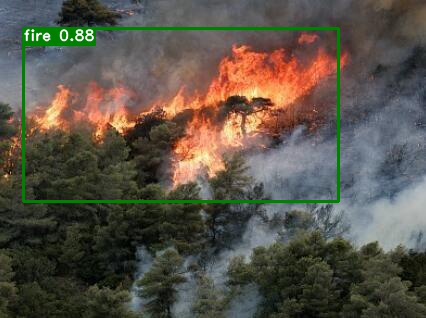

In [5]:
import paddlex as pdx
from PIL import Image


model = pdx.load_model('output/ppyolov2_r50vd_dcn/best_model')
#image_name = 'dataset/JPEGImages/002000.jpg'
image_name = 'output/26.jpg'
result = model.predict(image_name)
pdx.det.visualize(image_name, result, threshold=0.5, save_dir='./output/ppyolov2_r50vd_dcn')

img=Image.open('./output/ppyolov2_r50vd_dcn/visualize_26.jpg')
img.show()
